In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
%matplotlib inline
import pickle

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
!pip install pymorphy2
!pip install nltk
!pip install imbalanced-learn

In [ ]:
import nltk
import pymorphy2
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.combine import SMOTEENN

## Загрузка набора данных

In [ ]:
file_path = '/content/drive/MyDrive/Dekor/Learn.xlsx'

In [ ]:
df = pd.read_excel(file_path, sheet_name='one')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51875 entries, 0 to 51874
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Name      51875 non-null  object
 1   Category  51875 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 810.7+ KB
None


In [ ]:
print(df['Category'].value_counts())

Category
56    7115
17    6710
33    4060
29    3486
55    2581
      ... 
7       49
11      48
43      44
18      42
14      21
Name: count, Length: 61, dtype: int64


In [ ]:
# Максимальное количество слов
num_words = 20000
# Максимальная длина
max_news_len = 15
# Количество классов
nb_classes = 61

## Предобработка данных

In [ ]:
nltk.download('punkt')  # Токенизатор
nltk.download('stopwords')  # Список стоп-слов

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Инициализируем лемматизатор и список стоп-слов
morph = pymorphy2.MorphAnalyzer()
russian_stopwords = stopwords.words("russian")

In [ ]:
# Функция для предобработки текста
def preprocess_text_russian(text):
    text = text.lower()  # Приведение к нижнему регистру
    words = nltk.word_tokenize(text, language="russian")  # Токенизация
    words = [morph.parse(word)[0].normal_form for word in words if word not in russian_stopwords and word.isalpha()]  # Удаление стоп-слов и лемматизация
    return " ".join(words)

In [ ]:
# Применение функции к столбцу 'Name'
df['Processed_Name'] = df['Name'].apply(preprocess_text_russian)

## Обучение

In [ ]:
# Выделяем данные для обучения и правильные ответы
y_train = df['Category'] - 1  # категории начинаются с 1

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df['Processed_Name'])

In [ ]:
sequences = tokenizer.texts_to_sequences(df['Processed_Name'])
x_train = pad_sequences(sequences, maxlen=max_news_len)

In [ ]:
# Разделение данных на обучающую и валидационную выборки
X_train, X_val, Y_train, Y_val = train_test_split(x_train, utils.to_categorical(y_train, nb_classes), test_size=0.1, random_state=42)

In [ ]:
# Балансировка данных с использованием SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, np.argmax(Y_train, axis=1))

In [ ]:
# Преобразование меток обратно в one-hot encoding
Y_resampled = utils.to_categorical(y_resampled, nb_classes)

In [ ]:
# Подсчет весов классов для балансировки
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
model = Sequential([
    Embedding(num_words, 32, input_length=max_news_len),
    Conv1D(250, 5, padding='valid', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(nb_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Callback для сохранения лучшей модели
checkpoint_callback = ModelCheckpoint('dekor_best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [ ]:
# Обучение модели с учетом весов классов
history = model.fit(X_train, Y_train, epochs=8, batch_size=128, validation_data=(X_val, Y_val), callbacks=[checkpoint_callback], class_weight=class_weight_dict)

Epoch 1/8
365/365 [==============================] - ETA: 0s - loss: 2.7215 - accuracy: 0.5002
Epoch 1: val_accuracy improved from -inf to 0.78913, saving model to dekor_best_model.h5
365/365 [==============================] - 16s 38ms/step - loss: 2.7215 - accuracy: 0.5002 - val_loss: 0.8186 - val_accuracy: 0.7891
Epoch 2/8
  3/365 [..............................] - ETA: 10s - loss: 1.0181 - accuracy: 0.7500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


365/365 [==============================] - ETA: 0s - loss: 0.7300 - accuracy: 0.8288
Epoch 2: val_accuracy improved from 0.78913 to 0.88801, saving model to dekor_best_model.h5
365/365 [==============================] - 8s 22ms/step - loss: 0.7300 - accuracy: 0.8288 - val_loss: 0.4387 - val_accuracy: 0.8880
Epoch 3/8
364/365 [============================>.] - ETA: 0s - loss: 0.4508 - accuracy: 0.8908
Epoch 3: val_accuracy improved from 0.88801 to 0.90786, saving model to dekor_best_model.h5
365/365 [==============================] - 9s 26ms/step - loss: 0.4505 - accuracy: 0.8908 - val_loss: 0.3341 - val_accuracy: 0.9079
Epoch 4/8
365/365 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.9194
Epoch 4: val_accuracy improved from 0.90786 to 0.92367, saving model to dekor_best_model.h5
365/365 [==============================] - 8s 23ms/step - loss: 0.3342 - accuracy: 0.9194 - val_loss: 0.2898 - val_accuracy: 0.9237
Epoch 5/8
363/365 [============================>.] - 

In [ ]:
# После обучения, для сохранения лучшей модели на Google Диск, загружаем её из файла 'dekor_best_model.h5'
best_model_cnn = tf.keras.models.load_model('dekor_best_model.h5')

In [ ]:
# Указываем путь для сохранения на Google Диск
model_save_path = '/content/drive/My Drive/Colab Notebooks/dekor_best_model.h5'

In [ ]:
# Сохраняем лучшую модель
best_model_cnn.save(model_save_path)

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/dekor_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

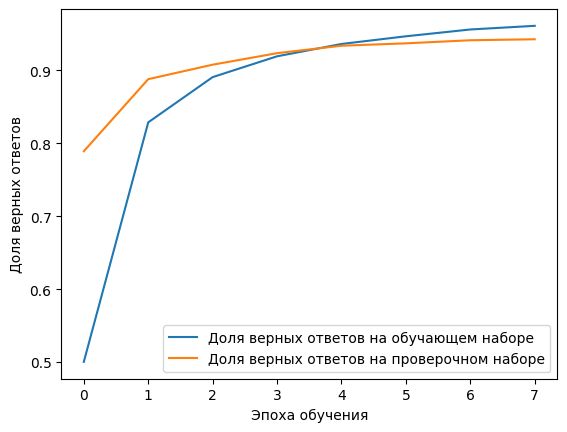

In [ ]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()